In [1]:
cd ../src

/home/sankha/Documents/programs/ML/densityNN/src


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy.stats import multivariate_normal, norm

from lib.density.utils import divergences, OptimizeNormalKL
from lib.density.sampling import RejectionSampling
from lib.density.integrate import importanceSampling as iS

# Sampling from a Distribution

## 1. Sampling from Standard Distributions

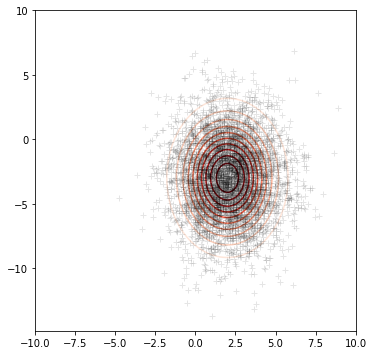

In [3]:
X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
theta = np.array(list(zip(X.flatten(), Y.flatten())))

mu    = np.array([2, -3])
sigma = np.array([
    [3, 0],
    [0, 8]
])

prob = multivariate_normal.pdf( theta, mu, sigma )
probPlot = prob.reshape(100, 100)

samples = np.random.multivariate_normal( mu, sigma, 5000 )

plt.figure(figsize=(5,5))
plt.axes([0.1, 0.1, 0.89, 0.89])
plt.plot(samples[:,0], samples[:,1], '+', mec='k', alpha=0.1)
plt.contour(X, Y, probPlot, cmap=plt.cm.Reds, levels=10)
plt.show()
plt.close('all')

## 2. Rejection Sampling

In this sampling method, we shall generate samples based upon the pdf. Note that this is a particularly slow process, and you may want to stay away from this. Sometimes, however, this might be the only method that is appropriate.

In [4]:
rSampler = RejectionSampling.RejectionSamplerUniform( multivariate_normal(mu, sigma).pdf )

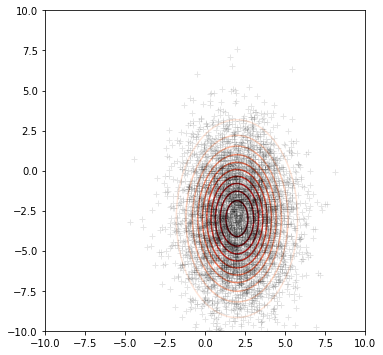

In [5]:
ranges = [[-10, 10], [-10, 10]]
N = 5000
samples = rSampler.sample(N, ranges)

plt.figure(figsize=(5,5))
plt.axes([0.1, 0.1, 0.89, 0.89])
plt.plot(samples[:,0], samples[:,1], '+', mec='k', alpha=0.1)
plt.contour(X, Y, probPlot, cmap=plt.cm.Reds, levels=10)
plt.show()
plt.close('all')

## 3. Importance Sampling

Importance Sampling is the idea that we want to solve the integral of the form:

\begin{equation*}
\mathbb E(f) = \int_{-\infty}^{\infty} f(\mathbf w) p(\mathbf w)  d \mathbf w
\end{equation*}

It is entirely possible that one samples from the distribution $p(\mathbf w)$. Under this formulation, the equation for importance sampling (in the limit of infinite samples $N$) would be given by the following:

\begin{align*}
\mathbb E(f) &= \int_{-\infty}^{\infty} f(\mathbf w) p(\mathbf w)  d \mathbf w \\
             &= \frac 1 N \sum_{i=1}^N {f(w_i)}, w_i \sim p(\mathbf w)
\end{align*}


In [7]:
def f(x):
    return (x ** 2).sum(axis=1)

ranges = [[-10, 10], [-10, 10]]
N = 5000

impSampleInt = iS.ImportanceSampleIntegrateUniform( f, multivariate_normal(mu, sigma).pdf )

In [8]:
for N in tqdm([10, 100, 1000], leave=True):
    result = []
    for j in tqdm(range(100), leave=True):
        r = impSampleInt.integrate(N, ranges)
        result.append(r)
    result = np.array(result)
    print(f'{N:10d} --> {result.mean()} (+- {result.std()})')

        10 --> 23.14250024853623 (+- 5.989433485804076)


       100 --> 23.629656925236972 (+- 1.8469073840375987)


      1000 --> 23.482265689562485 (+- 0.6479258099395351)



It is entirely possible that we use a parametrized form of the sampling. Under these circumstances, we shall sample directly using another density that we know, rather than using uniform sampling. That should significantly reduce the amount of time required. However for this we shall need to change the equations a bit:

\begin{align*}
\mathbb E(f) &= \int_{-\infty}^{\infty} f(\mathbf w) p(\mathbf w)  \frac {q(\mathbf w)} {q(\mathbf w)} d \mathbf w \\
             &= \int_{-\infty}^{\infty} \Big( f(\mathbf w)  \frac {p(\mathbf w)} {q(\mathbf w)} \Big) q(\mathbf w)  d \mathbf w \\
             &= \frac 1 N \sum_{i=1}^N w_s{f(w_i)}, w_i \sim q(\mathbf w)
\end{align*}

The important thing about this transformation is that the sampling form another distribution (like $q(\mathbf w)$) is typically easier to do.

For unnormalized distributions, we can use the following formula instead:

\begin{align*}
\mathbb E(f) &= \frac 1 {\sum_{i=1}^N w_s} \sum_{i=1}^N w_s{f(w_i)}, w_i \sim q(\mathbf w)
\end{align*}


In [11]:
class ImportanceSampleIntegrateNormal():
    
    def __init__(self, f, p, ranges=None):
        self.f = f
        self.p = p
        self.d = None
        self.ranges = ranges
        if ranges is not None:
            self.d = len(ranges)
        return
    
    def integrate(self, N, ranges = None):
        
        result = None
        if ranges is None:
            ranges = self.ranges
            
        assert ranges is not None, 'Ranges not provided for uniform sampling'
        d = len(ranges)
        mean = np.zeros(d)
        cov  = np.eye(d)*1000
        
        samples = np.random.multivariate_normal(mean, cov, N)
        p = self.p(samples)
        q = multivariate_normal(mean, cov).pdf(samples)
        f = self.f(samples)
        
        result = np.exp(np.log(f) + np.log(p) - np.log(q))
        result = result.sum()/N
        
        return result

In [12]:
def f(x):
    return (x ** 2).sum(axis=1)

ranges = [[-10, 10], [-10, 10]]
N = 5000

impSampleNorm = ImportanceSampleIntegrateNormal( f, multivariate_normal(mu, sigma).pdf )

for N in tqdm([10, 100, 1000], leave=True):
    result = []
    for j in tqdm(range(100), leave=True):
        r = impSampleNorm.integrate(N, ranges)
        result.append(r)
    result = np.array(result)
    print(f'{N:10d} --> {result.mean()} (+- {result.std()})')

        10 --> 19.79563306669982 (+- 64.01496167565911)


/home/sankha/Documents/programs/ML/densityNN/env/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


       100 --> 22.19966573376579 (+- 22.741131633359668)


      1000 --> 24.033822240258683 (+- 7.0296675749004365)



Now, we can use the KL divergence to get a parametrized Gaussian distribution ($q$) that is close to the distribution of $p$. Then, we should be able to get significantly better samples.

In [13]:
class ImportanceSampleIntegrateNormalAdaptive():
    
    def __init__(self, f, p, ranges=None):
        self.f = f
        self.p = p
        self.d = None
        self.ranges = ranges
        self.optKL = None
        if ranges is not None:
            self.d = len(ranges)
        return
    
    def integrate(self, N, ranges = None):
        
        result = None
        if ranges is None:
            ranges = self.ranges
            
        assert ranges is not None, 'Ranges not provided for uniform sampling'
        self.d = len(ranges)
        
        
        if self.optKL is None:
            lower, upper = zip(*ranges)
            mu_0 = np.zeros(self.d)

            tempSamples = np.random.uniform(lower, upper, (1000, self.d))
            pProb       = self.p(tempSamples)
            self.optKL = OptimizeNormalKL.OptimizeNormalKL(pProb, tempSamples)
            self.optKL.optimize(mu_0)

        samples = np.random.multivariate_normal( self.optKL.mu, self.optKL.sigma, N)
        p = self.p(samples)
        q = self.optKL.pdf( samples )
        f = self.f(samples)
        
        #result = np.exp(np.log(f) + np.log(p) - np.log(q))
        result = f * (p/q)
        result = result.sum()/N
        
        return result

In [14]:
def f(x):
    return (x ** 2).sum(axis=1)

ranges = [[-10, 10], [-10, 10]]
N = 5000

impSampleNormA = ImportanceSampleIntegrateNormalAdaptive( f, multivariate_normal(mu, sigma).pdf )

for N in tqdm([10, 100, 1000, 10000, 100000], leave=True):
    result = []
    for j in tqdm(range(100), leave=True):
        r = impSampleNormA.integrate(N, ranges)
        result.append(r)
    result = np.array(result)
    print(f'{N:10d} --> {result.mean()} (+- {result.std()})')

        10 --> 23.30155806342792 (+- 6.447476489393354)


       100 --> 23.877588175680263 (+- 2.2598270582000604)


      1000 --> 23.942200105754377 (+- 0.6378548766526428)


     10000 --> 23.976668744180827 (+- 0.19982995703646156)


    100000 --> 24.001588169544238 (+- 0.06265619513590498)



## Metropolis-Hastings (MH) Algorthm

The MH algorithm is sampling implementation of the MCMC algorithm in which we sample form a given distribution $p(\mathbf x)$. This is done using the following implementation. Given a current position in the parameter space $\mathbf x$, get a new position using a proposal rule $q(\mathbf x'| \mathbf x)$. The probability of acceptance of using this new state is given by the acceptance rate $r$, where:

\begin{equation*}
r = min(1, \frac {p(\mathbf x') q( \mathbf x | \mathbf x' )} {p(\mathbf x) q( \mathbf x' | \mathbf x )})
\end{equation*}

Since we have both $p(\mathbf x)$ on both the numerator and the demoninator, we can see that we can use an unnormalized density function for $p(\mathbf x)$ and this is still going to work. Typically, for the proposal rule $q$, one chooses a Gaussian distribution. This has two advantages:

1. The rule is symmetric. i.e. $q(\mathbf x | \mathbf x') = q(\mathbf x' | \mathbf x)$
2. Its easy to sample from this distribution

In [15]:
class MH:
    
    def __init__(self, p, d):
        self.p = p
        self.d = d
        self.cov = np.eye(d)
        self.x = np.zeros(d)
        return
    
    def update(self):
        
        xD = np.random.multivariate_normal(self.x, self.cov, 1).flatten()
        r = min([self.p(xD)/self.p(self.x), 1])
        if np.random.rand() < r:
            self.x = xD
        
        return self.x
    
    def sample(self, N):
        
        samples = [self.x]
        for _ in range(N-1):
            samples.append( self.update() )
        
        samples = np.array(samples)
        return samples
        
        

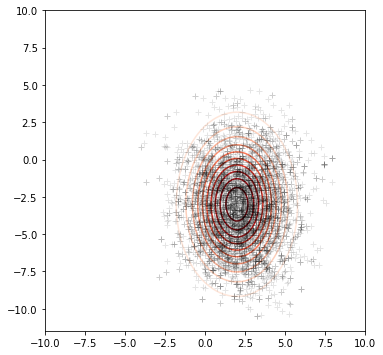

In [16]:
mu    = np.array([2, -3])
sigma = np.array([
    [3, 0],
    [0, 8]
])

mh = MH( multivariate_normal(mu, sigma).pdf, 2  )

samples = mh.sample(5000)

samples

plt.figure(figsize=(5,5))
plt.axes([0.1, 0.1, 0.89, 0.89])
plt.plot(samples[:,0], samples[:,1], '+', mec='k', alpha=0.1)
plt.contour(X, Y, probPlot, cmap=plt.cm.Reds, levels=10)
plt.show()
plt.close('all')